https://pytorch.org/docs/stable/library.html

In [ ]:
from typing import Callable
from cgtnnlib.AugmentedReLUNetwork import AugmentedReLUNetwork
from cgtnnlib.EvaluationParameters import EvaluationParameters
from cgtnnlib.ExperimentParameters import ExperimentParameters
from cgtnnlib.NetworkLike import NetworkLike
from cgtnnlib.PlotModel import PlotModel
from cgtnnlib.Report import Report, eval_report_key
from cgtnnlib.common import DATASETS, LEARNING_RATE, eval_inner
from cgtnnlib.training import train_model


REPORT = Report(dir="workbench/")
DATASET = DATASETS[2] #3
EPOCHS = 10
PP = [0.1, 0.5, 0.9]


MODEL_CONSTRUCTOR: Callable[[int, int, float], NetworkLike] = AugmentedReLUNetwork


def color_of_p(p: float) -> str:
    if p == PP[0]:
        return 'purple'
    elif p == PP[1]:
        return 'green'
    elif p == PP[2]:
        return 'blue'
    else:
        return 'red'

DATASET

Dataset(name='StudentPerformanceFactors.csv', learning_task=LearningTask(name='regression', criterion=MSELoss(), dtype=torch.float32), number=3, classes_count=1, data=DatasetData(train_dataset=<torch.utils.data.dataset.TensorDataset object at 0x18c019160>, test_dataset=<torch.utils.data.dataset.TensorDataset object at 0x18c0c37d0>, train_loader=<torch.utils.data.dataloader.DataLoader object at 0x18c05c9b0>, test_loader=<torch.utils.data.dataloader.DataLoader object at 0x18c0193a0>))

In [ ]:
import torch.optim as optim

from cgtnnlib.training import save_model_to_path


for p in PP:
    for iteration in range(1, 11):
        experiment_params = ExperimentParameters(
            iteration=iteration,
            p=p
        )

        # Training

        model = MODEL_CONSTRUCTOR(
            inputs_count=DATASET.features_count,
            outputs_count=DATASET.classes_count,
            p=experiment_params.p,
        )

        running_losses = train_model(
            model=model,
            dataset=DATASET,
            epochs=EPOCHS,
            experiment_params=experiment_params,
            criterion=DATASET.learning_task.criterion,
            optimizer=optim.Adam(
                model.parameters(),
                lr=LEARNING_RATE,
            )
        )

        model_path = f"workbench/WorkbenchModel{iteration}.pth"
        save_model_to_path(model, model_path)

        REPORT.record_running_losses(running_losses,
                                    model,
                                    DATASET,
                                    experiment_params)

        # Evaluation

        eval_params = EvaluationParameters(
            dataset=DATASET,
            model_path=model_path,
            experiment_parameters=experiment_params,
            report_key=eval_report_key(
                model_name=MODEL_CONSTRUCTOR.__name__,
                dataset_number=DATASET.number,
                p=p,
                iteration=iteration,
            )
        )

        eval_inner(
            eval_params=eval_params,
            experiment_params=experiment_params,
            constructor=MODEL_CONSTRUCTOR
        )

REPORT.see()
REPORT.save()

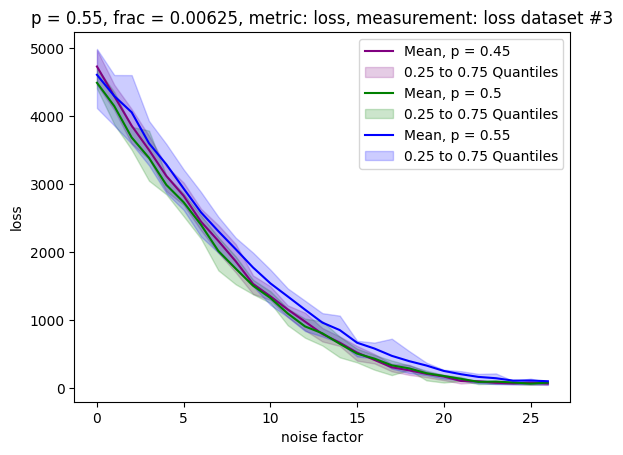

In [ ]:
import matplotlib.pyplot as plt

from cgtnnlib.analyze import plot_deviant_curves_on_ax_or_plt, search_curve_for_report

METRIC='loss'
MEASUREMENT='loss'
FRAC=0.0125*0.5


for p in PP:
    CURVE = search_curve_for_report(
        report_path=REPORT.path,
        model=PlotModel(
            measurement=MEASUREMENT,
            dataset_number=DATASET.number,
            metric=METRIC,
            p=p,
            frac=FRAC,
        )
    )

    color = color_of_p(p)
    plot_deviant_curves_on_ax_or_plt(
        ax_or_plt=plt,
        models=[{
            'curve': CURVE,
            'color': color,
            'label': f'Mean, p = {p}',
            'quantiles_color': color,
            'quantiles_label': '0.25 to 0.75 Quantiles',
        }],
        title=f'p = {p}, frac = {FRAC}, metric: {METRIC}, measurement: {MEASUREMENT} dataset #{DATASET.number}',
        xlabel='noise factor',
        ylabel=METRIC,
    )